In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency

# 1. Load the Data and Exploratory Data Analysis (EDA)
    - inspect the dataset to understand features and targets

In [3]:
df = pd.read_csv("data/Loan_Default_kaggle.csv")
df.columns

Index(['ID', 'year', 'loan_limit', 'Gender', 'approv_in_adv', 'loan_type',
       'loan_purpose', 'Credit_Worthiness', 'open_credit',
       'business_or_commercial', 'loan_amount', 'rate_of_interest',
       'Interest_rate_spread', 'Upfront_charges', 'term', 'Neg_ammortization',
       'interest_only', 'lump_sum_payment', 'property_value',
       'construction_type', 'occupancy_type', 'Secured_by', 'total_units',
       'income', 'credit_type', 'Credit_Score', 'co-applicant_credit_type',
       'age', 'submission_of_application', 'LTV', 'Region', 'Security_Type',
       'Status', 'dtir1'],
      dtype='object')

## 1.1 Understand the data

In [4]:
# shape & types
print(df.shape)
print(df.info())
print(df.dtypes)

(148670, 34)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges 

In [5]:
# preview the first few rows.
print("First 5 rows:")
print(df.head())

First 5 rows:
      ID  year loan_limit             Gender approv_in_adv loan_type  \
0  24890  2019         cf  Sex Not Available         nopre     type1   
1  24891  2019         cf               Male         nopre     type2   
2  24892  2019         cf               Male           pre     type1   
3  24893  2019         cf               Male         nopre     type1   
4  24894  2019         cf              Joint           pre     type1   

  loan_purpose Credit_Worthiness open_credit business_or_commercial  ...  \
0           p1                l1        nopc                  nob/c  ...   
1           p1                l1        nopc                    b/c  ...   
2           p1                l1        nopc                  nob/c  ...   
3           p4                l1        nopc                  nob/c  ...   
4           p1                l1        nopc                  nob/c  ...   

   credit_type  Credit_Score  co-applicant_credit_type    age  \
0          EXP           758   

In [7]:
print("Last 5 rows:")
print(df.tail())

Last 5 rows:
            ID  year loan_limit             Gender approv_in_adv loan_type  \
148665  173555  2019         cf  Sex Not Available         nopre     type1   
148666  173556  2019         cf               Male         nopre     type1   
148667  173557  2019         cf               Male         nopre     type1   
148668  173558  2019         cf             Female         nopre     type1   
148669  173559  2019         cf             Female         nopre     type1   

       loan_purpose Credit_Worthiness open_credit business_or_commercial  ...  \
148665           p3                l1        nopc                  nob/c  ...   
148666           p1                l1        nopc                  nob/c  ...   
148667           p4                l1        nopc                  nob/c  ...   
148668           p4                l1        nopc                  nob/c  ...   
148669           p3                l1        nopc                  nob/c  ...   

        credit_type  Credit_Sco

## 1.2 Drop duplicates and remove columns that have one unique value

In [9]:
# Drop ID since it is just an identifier.
df = df.drop(columns=['ID'])

# Drop duplicates on features + targes
df = df.drop_duplicates()
print(df.shape)

constant_cols = df.columns[df.nunique(dropna=False) == 1]
print("Dropped constant columns:", list(constant_cols))
df = df.drop(columns=constant_cols)

(148670, 33)
Dropped constant columns: ['year']


## 1.3 Investiage conflicting rows (same features, different target)
conflict rows may indicate:
- Data entry error.
- Missing distinguishing features.
- Feature contains target info.

In [10]:
# Find rows with identical features but different targets
conflicts = df.groupby(list(df.columns.difference(['Status']))).agg({'Status': pd.Series.nunique})
conflicts = conflicts[conflicts['Status'] > 1]
print(conflicts)

Empty DataFrame
Columns: [Status]
Index: []


## 1.4 Visualize Distribution

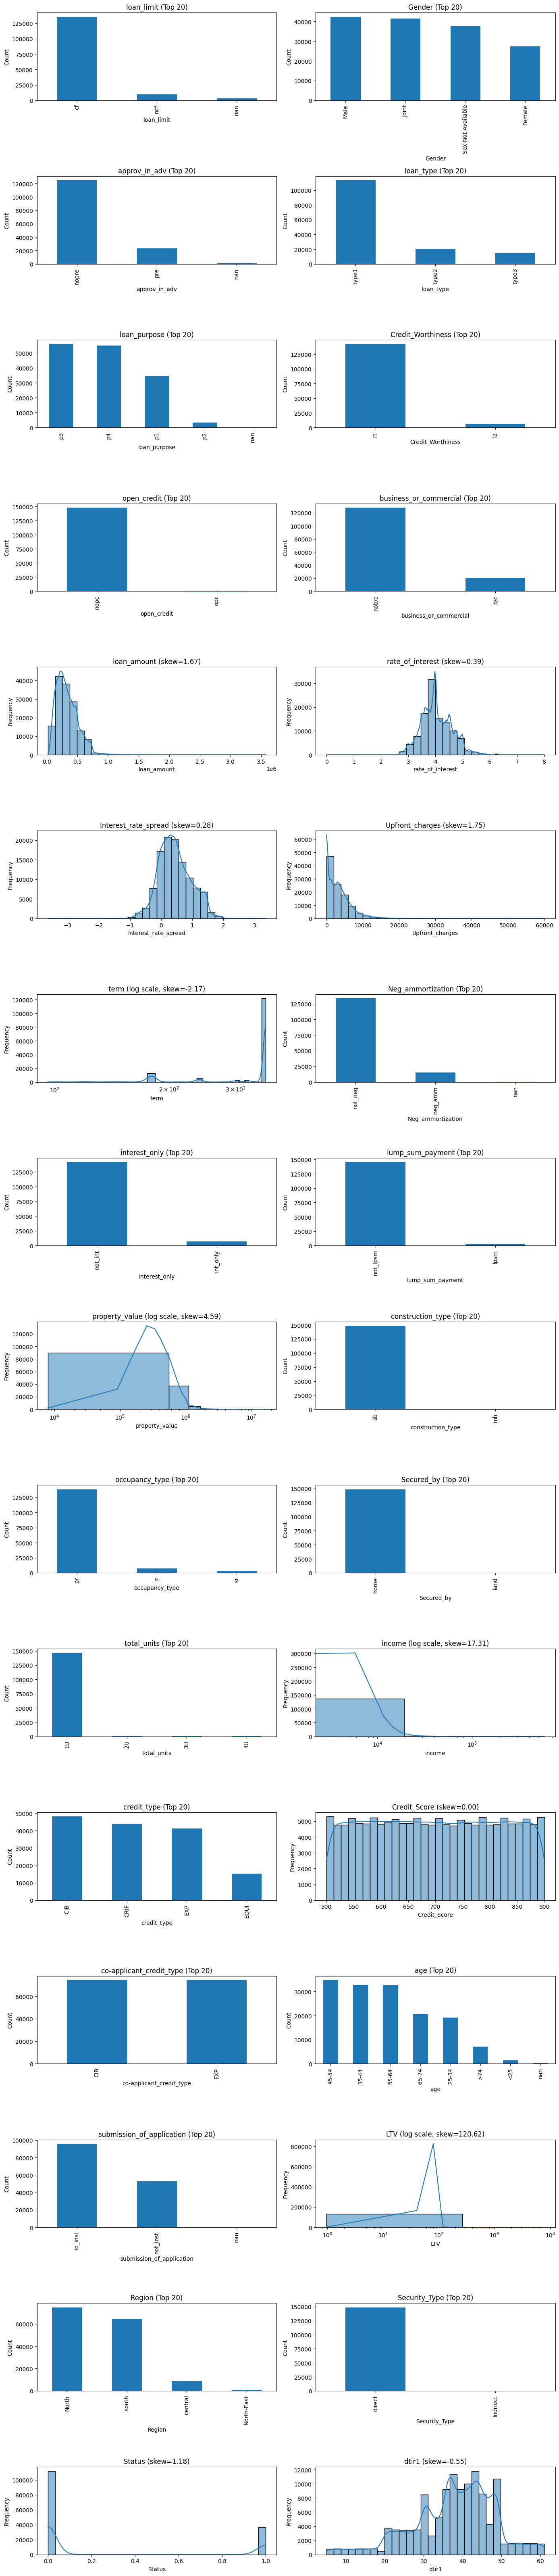

In [11]:
def plot_all_features_grid(df, top_n_categories=20, log_threshold_skew=2):
    num_cols = df.shape[1]
    n_cols = 2
    n_rows = int(np.ceil(num_cols / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
    axes = axes.flatten()

    for idx, col in enumerate(df.columns):
        ax = axes[idx]
        if pd.api.types.is_numeric_dtype(df[col]):
            skewness = df[col].skew(skipna=True)
            log_scale = abs(skewness) > log_threshold_skew
            sns.histplot(df[col].dropna(), kde=True, bins=30, ax=ax)
            if log_scale:
                ax.set_xscale('log')
                ax.set_title(f'{col} (log scale, skew={skewness:.2f})')
            else:
                ax.set_title(f'{col} (skew={skewness:.2f})')
            ax.set_xlabel(col)
            ax.set_ylabel('Frequency')
        else:
            vc = df[col].value_counts(dropna=False).head(top_n_categories)
            vc.plot(kind='bar', ax=ax)
            ax.set_title(f'{col} (Top {top_n_categories})')
            ax.set_xlabel(col)
            ax.set_ylabel('Count')

    # Hide any unused subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_all_features_grid(df)  # Set to True to save plots

One dominant category – top category proportion ≥ threshold (e.g., 0.8)

Multiple frequent categories – low-cardinality, no single dominant category

High cardinality – many unique values (≥ threshold, e.g., 20)

In [31]:
# Identify features and target
target = 'Status'
features = df.columns.drop(target)

# Features only
X = df.drop(columns=[target])

# Target only
y = df[target]

# Optional: check shapes
print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (148670, 31)
Target shape: (148670,)


In [32]:
def categorize_categorical_features(df, dominance_threshold=0.8, high_cardinality_threshold=20):
    """
    Classify categorical features into:
    - one dominant category
    - multiple frequent categories (low-cardinality)
    - high cardinality
    
    Parameters:
        df (pd.DataFrame): Input DataFrame
        dominance_threshold (float): Top category proportion to consider "dominant"
        high_cardinality_threshold (int): Number of unique categories to consider "high cardinality"
    
    Returns:
        dict: {'one_dominant': [...], 'multi_frequent': [...], 'high_cardinality': [...]}
    """
    one_dominant = []
    multi_frequent = []
    high_cardinality = []

    cat_cols = df.select_dtypes(include='object').columns

    for col in cat_cols:
        n_unique = df[col].nunique(dropna=False)
        counts = df[col].value_counts(normalize=True, dropna=False)
        top_prop = counts.iloc[0]

        if n_unique >= high_cardinality_threshold:
            high_cardinality.append(col)
        elif top_prop >= dominance_threshold:
            one_dominant.append(col)
        else:
            multi_frequent.append(col)

    return {
        'one_dominant': one_dominant,
        'multi_frequent': multi_frequent,
        'high_cardinality': high_cardinality
    }
categorical_features = categorize_categorical_features(X, dominance_threshold=0.8, high_cardinality_threshold=20)
print(categorical_features)

{'one_dominant': ['loan_limit', 'approv_in_adv', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'construction_type', 'occupancy_type', 'Secured_by', 'total_units', 'Security_Type'], 'multi_frequent': ['Gender', 'loan_type', 'loan_purpose', 'credit_type', 'co-applicant_credit_type', 'age', 'submission_of_application', 'Region'], 'high_cardinality': []}


In [33]:
def categorize_numerical_features(df, skew_moderate=0.5, skew_high=1.0):
    """
    Categorize numeric features into symmetric, skewed, heavy-tailed,
    and apply appropriate preprocessing / imputation.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame with numeric features
        skew_moderate (float): Threshold for moderate skew
        skew_high (float): Threshold for high skew
    
    Returns:
        dict: Feature categories {'symmetric': [], 'moderate_skew': [], 'heavy_skew': []}
    """
    df_numeric = df.select_dtypes(include=np.number).copy()
    feature_categories = {'symmetric': [], 'moderate_skew': [], 'heavy_skew': []}

    for col in df_numeric.columns:
        skew_val = df_numeric[col].skew()
        
        # Classify feature
        if abs(skew_val) <= skew_moderate:
            category = 'symmetric'
        elif abs(skew_val) <= skew_high:
            category = 'moderate_skew'
        else:
            category = 'heavy_skew'
        
        feature_categories[category].append(col)
    return feature_categories
numerical_features = categorize_numerical_features(X)

print(numerical_features)

{'symmetric': ['rate_of_interest', 'Interest_rate_spread', 'Credit_Score'], 'moderate_skew': ['dtir1'], 'heavy_skew': ['loan_amount', 'Upfront_charges', 'term', 'property_value', 'income', 'LTV']}


## 1.5 Missing Values

Upfront_charges              0.266644
Interest_rate_spread         0.246445
rate_of_interest             0.245100
dtir1                        0.162245
property_value               0.101554
LTV                          0.101554
income                       0.061546
loan_limit                   0.022493
approv_in_adv                0.006107
submission_of_application    0.001345
age                          0.001345
loan_purpose                 0.000901
Neg_ammortization            0.000814
term                         0.000276
dtype: float64


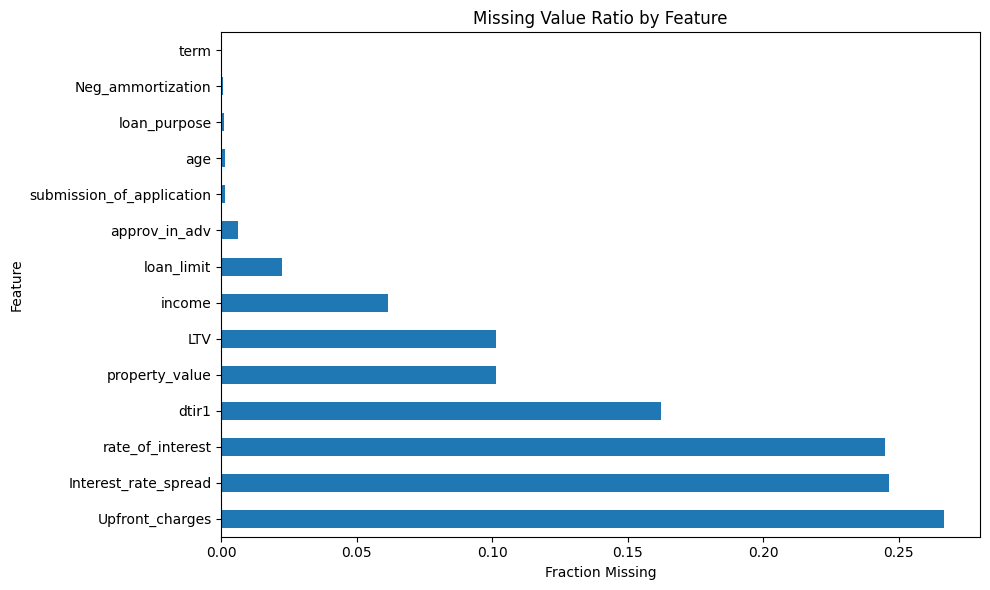

['Upfront_charges', 'Interest_rate_spread', 'rate_of_interest']


In [46]:
def calculate_missing_ratio(df): 
    # Calculate the proportion of missing values
    missing_ratio = df.isnull().mean().sort_values(ascending=False)

    # Display only columns with missing values
    missing_ratio = missing_ratio[missing_ratio > 0]
    print(missing_ratio)

    # Plot missing value ratio
    plt.figure(figsize=(10, 6))
    missing_ratio.plot(kind='barh')
    plt.title("Missing Value Ratio by Feature")
    plt.xlabel("Fraction Missing")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    return missing_ratio
missing_ratio = calculate_missing_ratio(X)
threshold = 0.2

# Get columns with high missing ratio
high_missing_ratio_features = missing_ratio[missing_ratio > threshold].index.tolist()
print(high_missing_ratio_features)


## 1.6 Feature Importance

                      feature    importance
10       Interest_rate_spread  3.395391e-01
11            Upfront_charges  2.864765e-01
9            rate_of_interest  1.782137e-01
22                credit_type  5.738065e-02
27                        LTV  3.608211e-02
16             property_value  3.606364e-02
30                      dtir1  1.674344e-02
21                     income  8.573605e-03
8                 loan_amount  5.866181e-03
24   co-applicant_credit_type  5.652774e-03
15           lump_sum_payment  4.694195e-03
26  submission_of_application  4.110659e-03
13          Neg_ammortization  4.046116e-03
7      business_or_commercial  3.521872e-03
3                   loan_type  2.961063e-03
12                       term  2.290697e-03
4                loan_purpose  1.452588e-03
18             occupancy_type  9.519996e-04
23               Credit_Score  8.986608e-04
1                      Gender  7.645979e-04
0                  loan_limit  7.067566e-04
25                        age  6

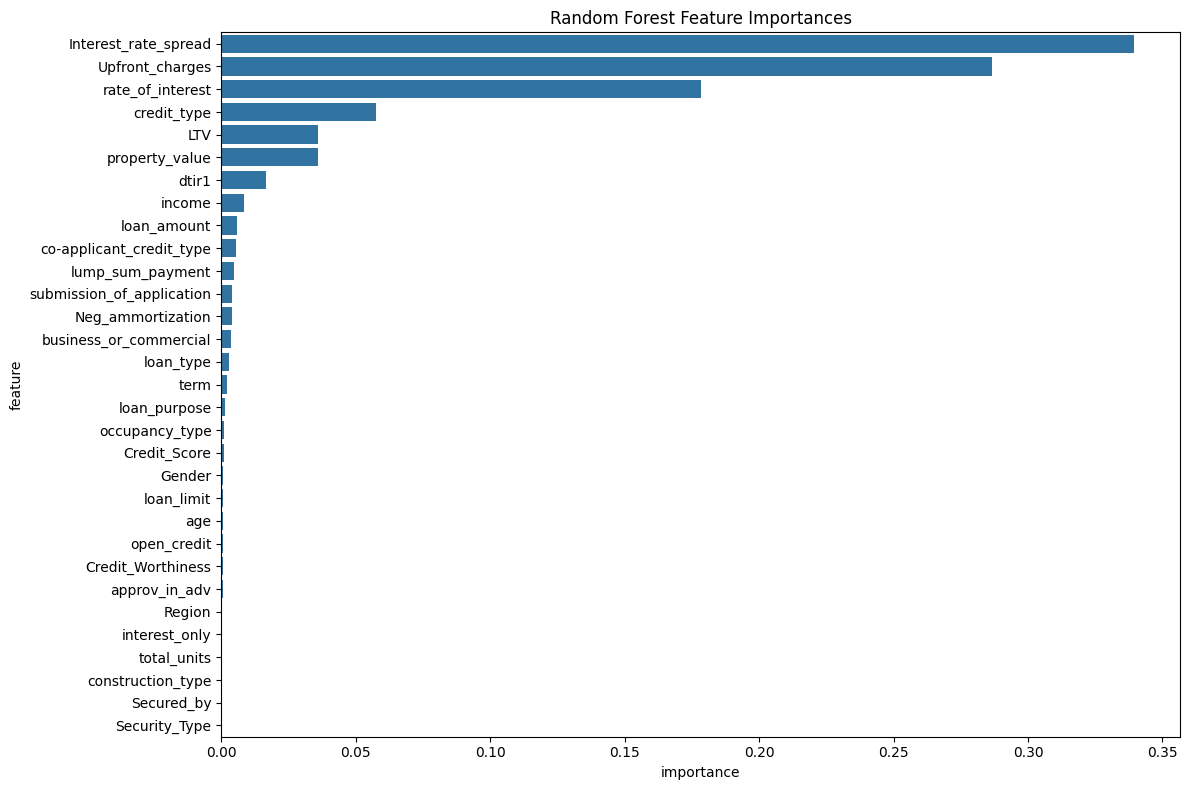

In [ ]:
def calculate_feature_importance(df, features, target):
    # Copy the original dataframe
    df_temp = df.copy()

    # Encode categorical columns and impute missing values

    for col in features:
        if df_temp[col].dtype == 'object' or df_temp[col].dtype.name == 'category':
            df_temp[col] = df_temp[col].fillna(df_temp[col].mode()[0])  # Fill with most frequent
            le = LabelEncoder()
            df_temp[col] = le.fit_transform(df_temp[col])
        else:
            df_temp[col] = df_temp[col].fillna(df_temp[col].median())  # Fill with median

    # Prepare data
    X = df_temp[features]
    y = df_temp[target]

    # Split into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train RandomForestClassifier
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Extract feature importances
    feature_importances = pd.DataFrame({
        'feature': features,
        'importance': rf.feature_importances_
    }).sort_values(by='importance', ascending=False)

    # Print or display
    print(feature_importances)

    # Optional: plot
    plt.figure(figsize=(12, 8))
    sns.barplot(data=feature_importances, y='feature', x='importance')
    plt.title('Random Forest Feature Importances')
    plt.tight_layout()
    plt.show()

    return feature_importances


feature_importances = calculate_feature_importance(df, features, target)

In [24]:
# Get features with low importance
threshold = 0.005
low_importance = feature_importances[feature_importances['importance'] < threshold]
print("Features below importance threshold:")
print(low_importance.feature)

Features below importance threshold:
15             lump_sum_payment
26    submission_of_application
13            Neg_ammortization
7        business_or_commercial
3                     loan_type
12                         term
4                  loan_purpose
18               occupancy_type
23                 Credit_Score
1                        Gender
0                    loan_limit
25                          age
6                   open_credit
5             Credit_Worthiness
2                 approv_in_adv
28                       Region
14                interest_only
20                  total_units
17            construction_type
19                   Secured_by
29                Security_Type
Name: feature, dtype: object


In [26]:
# Get features with high importance
threshold = 0.05
high_importance = feature_importances[feature_importances['importance'] >= threshold]
print("Features above importance threshold:")
high_importance_features = high_importance.feature.to_list()
print(high_importance_features)

Features above importance threshold:
['Interest_rate_spread', 'Upfront_charges', 'rate_of_interest', 'credit_type']


# 2. Preprocess the Data.
- Handle missing values.
- Deal with Outliers.
- Encode categorical variables if needed.
- split data into training, validation, and test sets

Principle of handling missing values:
Understand missingness first (MCAR, MAR, MNAR) — it informs whether simple imputation is unbiased.

Use feature importance as a secondary guide — focus computational effort on predictive features.

High-cardinality features → avoid naive one-hot; use target encoding or embeddings.

Iterative/tree-based imputation works well for numeric + low-cardinality features.

MNAR is tricky — treat missing as special category if unsure.

## 2.1 Check MCAR/MAR/MNAR


- **MCAR**: missing completely at random.
    - simple imputation is fine.
- **MAR**: missing at random.
    - model-based imputation is preferable.
- **MNAR**: missing NOT at random.
    - sometimes use a “Missing” category or model missingness explicitly.

For each column with missing values:
- Run t-test / chi2 against all other columns
- If all p-values > 0.05 → treat as MCAR
- Else → treat as MAR
- If domain knowledge suggests missingness depends on its own value → treat as MNAR
- Sample sizes matter: If there are very few missing rows, t-test or chi2 may be underpowered → may falsely appear as MCAR.

In [22]:
def mcar_mar_analysis(df):
    MCAR = []  # list of columns consistent with MCAR
    not_mcar = {}  # dict: col -> list of other_cols with significant dependence

    for col in df.columns:
        if df[col].isnull().sum() == 0:
            continue  # skip columns with no missing values

        missing_mask = df[col].isnull()
        dependent_cols = []

        for other_col in df.columns:
            if other_col == col:
                continue

            # Numerical other_col → t-test
            if pd.api.types.is_numeric_dtype(df[other_col]):
                sample1 = df.loc[missing_mask, other_col].dropna()
                sample2 = df.loc[~missing_mask, other_col].dropna()
                if len(sample1) > 0 and len(sample2) > 0:
                    _, p_val = ttest_ind(sample1, sample2, equal_var=False)
                    if p_val <= 0.05:
                        dependent_cols.append(other_col)

            # Categorical other_col → chi2 test
            else:
                contingency = pd.crosstab(df[other_col], missing_mask)
                if contingency.shape[0] > 0 and contingency.shape[1] > 0:
                    _, p_val, _, _ = chi2_contingency(contingency)
                    if p_val <= 0.05:
                        dependent_cols.append(other_col)

        # Decide MCAR or MAR
        if len(dependent_cols) == 0:
            MCAR.append(col)
        else:
            not_mcar[col] = dependent_cols

    return MCAR, not_mcar

MCAR, not_mcar = mcar_mar_analysis(df)
print("MCAR columns:", MCAR)
print("Columns with missingness depending on other columns (MAR):", not_mcar)

/mnt/c/Users/yaoqi/Qiulan/Qiulan/study/github/Loan-Default-Prediction/.venv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/mnt/c/Users/yaoqi/Qiulan/Qiulan/study/github/Loan-Default-Prediction/.venv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/mnt/c/Users/yaoqi/Qiulan/Qiulan/study/github/Loan-Default-Prediction/.venv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Re

MCAR columns: []
Columns with missingness depending on other columns (MAR): {'loan_limit': ['Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'business_or_commercial', 'loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'property_value', 'co-applicant_credit_type', 'age', 'LTV', 'Region', 'Status', 'dtir1'], 'approv_in_adv': ['loan_limit', 'loan_purpose', 'Credit_Worthiness', 'loan_amount', 'rate_of_interest', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'property_value', 'occupancy_type', 'total_units', 'submission_of_application'], 'loan_purpose': ['approv_in_adv', 'loan_type', 'Credit_Worthiness', 'business_or_commercial', 'Upfront_charges', 'term', 'interest_only', 'property_value', 'credit_type', 'age', 'submission_of_application', 'LTV'], 'rate_of_interest': ['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', '

## 2.2 Feature importance & missing rate

- High importance + high missing rate
    - Model-based imputation is preferred.

- Low importance + high missing rate
    - Consider dropping or simple imputation.

# 3. Train a Model
Since it is a binary classification problem, use models like
- Logistic Regression.
- Random Forest.
- XGBoost.

# 4. Evaluate the Model.
Metrics include 
- Accuracy.
- Precision, Recall, F1-score.
- PR-AUC/ROC-AUC.
